In [169]:
import copy
import time
import os
import glob

from ib_async import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *

pct_delta = lambda new, old: ((new - old) / old) * 100 if old != 0 else None

In [50]:
label_to_nums = {
    "trend" : 1,
    "range" : 0,
}

trend_range_cutoff = 1.0

In [168]:
def quantReqHistoricalData(secType: str, symbol: str, endDateTime: str, durationStr: str, barSizeSetting: str):

    """
    Parameters
    ------------
    secType: str
        Type of security
        'STK' = Stock (or ETF)
        'OPT' = Option
        'FUT' = Future
        'IND' = Index
        'FOP' = Futures option
        'CASH' = Forex pair
        'CFD' = CFD
        'BAG' = Combo
        'WAR' = Warrant
        'BOND' = Bond
        'CMDTY' = Commodity
    symbol: str
        The contract (or its underlying) symbol
    endDateTime: str
        Can be set to '' to indicate the current time, or it can be given as a datetime.date or datetime.datetime, or it can be given as a string in 'yyyyMMdd HH:mm:ss' format
    durationStr: str
        How far back from the endDateTime to grab data
        Accepts changes to the number
        '60 S', '30 D', '13 W', '6 M', '10 Y'.
    barSizeSetting: str
        Must be one of: '1 secs', '5 secs', '10 secs' 15 secs', '30 secs', '1 min', '2 mins', '3 mins', '5 mins', '10 mins', '15 mins', '20 mins', '30 mins', '1 hour', '2 hours',
        '3 hours', '4 hours', '8 hours', '1 day', '1 week', '1 month'.
    """

    volume_bars, volatility_bars, all_bars = None, None, None

    try:

        contract = Contract(secType=secType, symbol=symbol, exchange='SMART', currency='USD')
        volume_bars = ib.reqHistoricalData(
            contract, endDateTime=endDateTime, durationStr=durationStr,
            barSizeSetting=barSizeSetting, whatToShow='TRADES', useRTH=True, timeout=0)

        # Convert to pandas dataframe
        volume_bars = util.df(volume_bars)
        volume_bars.sort_values(by=['date'], ascending=False, inplace=True)
        volume_bars.columns = ["date" if col == "date" else "volume_" + col for col in volume_bars.columns]

        """
        volatility_bars = ib.reqHistoricalData(
            contract, endDateTime=endDateTime, durationStr=durationStr,
            barSizeSetting=barSizeSetting, whatToShow='HISTORICAL_VOLATILITY', useRTH=True, timeout=0)

        volatility_bars = util.df(volatility_bars)
        volatility_bars.sort_values(by=['date'], ascending=False, inplace=True)
        volatility_bars.columns = ["date" if col == "date" else "volatility_" + col for col in volatility_bars.columns]
        """

        # all_bars = pd.merge(volume_bars, volatility_bars, on="date", how="inner")

    except Exception as e:

        print(e)

    finally:

        # Make sure to disconnect the client once finished with client work
        ib.disconnect()
        time.sleep(5)

    return volume_bars


def extract_session_info(session_bars: pd.DataFrame, threshold: float = trend_range_cutoff):

    """
    Given a session_bars find out if the session is a range session or trend sessio
    Also extract useful information from the session

    Parameters
    ----------
    session_bars: pd.Dataframe
        the session to investigate
    threshold: float
        threshold for deciding if trend or range

    Returns
    ----------
    session_open_price: float
        Price at the opening of the session
    session_close_price: float
        Price at the close of the session
    session_max_price: float
        Maximum price during the session
    session_min_price: float
        Minimum price during the session
    session_volume_total: float
        Total number of units traded during the session
    session_nr_trades: float
        Total number of trades during the session
    session_volume_per_trade
        Average number of shares per trade in the session
    """


    volatility = session_bars.volume_close.pct_change().std() * (len(session_bars) ** 0.5)
    trend_score = (session_bars.volume_close.max() - session_bars.volume_close.min()) / (volatility * session_bars.volume_close.iloc[0] + 1e-6)
    # label = 'trend' if abs(trend_score) > threshold else 'range'
    label = 1 if abs(trend_score) > threshold else 0
    
    session_open_price = session_bars.loc[session_bars['date'].idxmin(), "volume_open"]
    session_close_price = session_bars.loc[session_bars['date'].idxmin(), "volume_close"]
    session_max_price = session_bars["volume_high"].max()
    session_min_price = session_bars["volume_low"].max()
    session_volume_total = session_bars["volume_volume"].sum()
    session_nr_trades =   session_bars["volume_barCount"].sum()
    session_volume_per_trade = session_bars["volume_volume"].sum() / session_bars["volume_barCount"].sum()
    session_info = {
        "label": label,
        "session_open_price": session_open_price,
        "session_close_price": session_close_price,
        "session_max_price": session_max_price,
        "session_min_price": session_min_price,
        "session_volume_total": session_volume_total,
        "session_nr_trades": session_nr_trades,
        "session_volume_per_trade": session_volume_per_trade,
    }

    return session_info 

def volume_bars_to_labelled_session(volume_bars: pd.DataFrame):

    """
    Convert volume_bars to labelled_sessions

    Parameters
    ----------
    volume_bars: pd.DataFrame
        dataframe of volume bars

    Returns
    ----------
    labelled_session: dict
        {date: {'session_df': session_df, 'session_label': label_session(session_df)
    """
    
    volume_bars_copy = copy.deepcopy(volume_bars)
    volume_bars_copy['date_days'] = volume_bars_copy['date'].astype(str).str.split(' ').str[0]
    volume_bars_groupby_date = {key: values for key, values in volume_bars_copy.groupby("date_days")}

    
    labelled_sessions = {date: {'session_df': session_df,
                                'session_info': extract_session_info(session_df),
                                }

                         
                         for date, session_df in volume_bars_groupby_date.items()}

    return labelled_sessions

def volume_bars_benchmark1(volume_bars: pd.DataFrame, symbol: str):

    """
    Given a volume bars, find out benchmark
    New quant strategy is only worth if lower risk or higher return than benchmark
    1. Hold and sell strategy
    
    Parameters
    ----------
    volume_bars: pd.DataFrame
        bars with the volume

    Returns
    ----------
    """

    volume_bars_copy = copy.deepcopy(volume_bars)

    # Strategy 1 Buy at beginning of year and sell at the end of the year
    volume_bars_copy['year'] = volume_bars_copy['date'].astype(str).str.split('-').str[0]
    annual_volume_bars = volume_bars_copy.groupby('year')
    annual_returns = np.zeros((len(annual_volume_bars), 2))
    for index, (year, annual_volume_bars) in enumerate(annual_volume_bars):
            
        year_open = annual_volume_bars.loc[annual_volume_bars["date"].idxmin(), "volume_open"]
        year_close = annual_volume_bars.loc[annual_volume_bars["date"].idxmax(), "volume_close"]
        annual_returns[index, 0] = year
        annual_returns[index, 1] = pct_delta(year_close, year_open)

    annual_returns_df = pd.DataFrame(annual_returns, columns = ["year", "return"])
    annual_returns_df_mean = (annual_returns_df["return"].mean())
    
    return annual_returns_df, annual_returns_df_mean

def create_bracket_order(secType: str, symbol: str, action: str, quantity: int, entry_price: float, take_profit_price: float, stop_loss_price: float):

    """
    Parameters
    ------------
    secType: str
        Type of security
        'STK' = Stock (or ETF)
        'OPT' = Option
        'FUT' = Future
        'IND' = Index
        'FOP' = Futures option
        'CASH' = Forex pair
        'CFD' = CFD
        'BAG' = Combo
        'WAR' = Warrant
        'BOND' = Bond
        'CMDTY' = Commodity
    symbol: str
        The contract (or its underlying) symbol
    action: str
        BUY or SELL
    quantity: int
        The number to buy
    entry_price: float
        Entry price, set below market price to immediately execute the order at next available time
    take_profit_price: float
        Take Profit
    stop_loss_price: float
        Stop loss

    """

    contract = Contract(secType=secType, symbol=symbol, exchange='SMART', currency='USD')
    
    # Define order parameters
    quantity = 10
    entry_price = 150  # Your entry price
    take_profit_price = 160  # Target price
    stop_loss_price = 145  # Stop loss price
    
    # Create the bracket order
    bracket = ib.bracketOrder(
        action=action,
        quantity=quantity,
        limitPrice=entry_price,
        takeProfitPrice=take_profit_price,
        stopLossPrice=stop_loss_price
    )
    
    # Place the bracket order
    for order in bracket:
        ib.placeOrder(contract, order)
    
    print("Bracket order placed successfully!")



In [69]:
util.startLoop()  # uncomment this line when in a notebook

ib = IB()
ib.connect('127.0.0.1', 7496, clientId=2)
ib.reqMarketDataType(1)  # Use free, delayed, fr ozen data
volume_bars = quantReqHistoricalData(secType = "STK", symbol = "TSLA", endDateTime = "", durationStr = "10 Y", barSizeSetting = "3 mins")

volume_bars.to_csv("TSLA_10Y3mins_RTH.csv", index=False)

ib.disconnect()

In [171]:
volume_bars = pd.read_csv(os.path.join("stocks_past_data","AAPL_10Y3mins_RTH.csv"))
labelled_sessions = volume_bars_to_labelled_session(volume_bars)

newdf = pd.DataFrame([{'date': date, **values['session_info']} for date, values in labelled_sessions.items()])

display(newdf)

,date,label,session_open_price,session_close_price,session_max_price,session_min_price,session_volume_total,session_nr_trades,session_volume_per_trade
0,2015-05-27,1,32.57,32.58,33.07,33.04,153466400.0,184026,833.938683
1,2015-05-28,0,32.97,32.95,32.99,32.96,100008000.0,109680,911.816193
2,2015-05-29,1,32.81,32.82,32.86,32.81,149351200.0,163941,911.005789
3,2015-06-01,0,32.84,32.79,32.85,32.74,110002576.0,124031,886.895824
4,2015-06-02,1,32.47,32.56,32.67,32.64,121245600.0,125181,968.562322
...,...,...,...,...,...,...,...,...,...
2510,2025-05-19,1,207.78,206.34,209.48,209.23,26756989.0,147381,181.549786
2511,2025-05-20,1,207.67,207.12,208.47,208.14,23605310.0,126482,186.629797
2512,2025-05-21,1,205.17,204.84,207.04,206.74,37401976.0,210840,177.395067
2513,2025-05-22,1,200.71,201.05,202.75,202.45,29211675.0,156962,186.106669


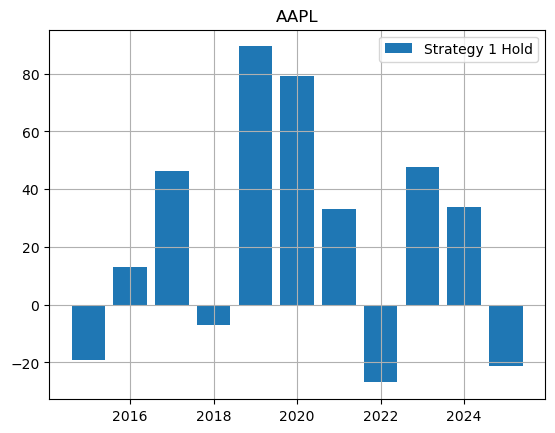

In [166]:


annual_returns_df, annual_returns_df_mean = volume_bars_benchmark(volume_bars, "AAPL")


symbol = "AAPL"
plt.bar(annual_returns_df["year"], annual_returns_df["return"], label="Strategy 1 Hold")
plt.title(symbol)
plt.grid()
plt.legend()
plt.show()

In [173]:
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target])
    return np.array(X), np.array(y)

def create_prediction_model(df: pd.DataFrame, target: str = "label"):

    """
    # Predict the next day's label
    next_day_features = np.expand_dims(df.iloc[-SEQ_LENGTH:][features].values, axis=0)
    predicted_label = model.predict(next_day_features)
    
    # Convert probability to binary label
    predicted_label = (predicted_label > 0.5).astype(int)
    print(f"Predicted label for the next day: {predicted_label[0][0]}")
    """
    
    prediction_model = None
    
    df = copy.deepcopy(df)
    features = [i for i in list(newdf.columns) if i not in ["label", "date"]]

    # Feature Engineering
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Past 29 sessions in CN, given 3 sessions per day, means 10 sessions in US
    SEQ_LENGTH = 10  
    X, y = create_sequences(df, features, target, SEQ_LENGTH)

    # Split data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    # Define LSTM model
    model = Sequential([
        LSTM(50, activation="relu", return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
        LSTM(50, activation="relu"),
        Dense(25, activation="relu"),
        Dense(1, activation="sigmoid")  # Binary classification
    ])
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))
    
    return model

prediction_model = create_prediction_model(newdf)




Epoch 1/20


C:\Users\dawnquake\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8310 - loss: 0.5176 - val_accuracy: 0.8563 - val_loss: 0.4304
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8389 - loss: 0.4484 - val_accuracy: 0.8563 - val_loss: 0.4268
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8345 - loss: 0.4501 - val_accuracy: 0.8563 - val_loss: 0.4357
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8379 - loss: 0.4478 - val_accuracy: 0.8563 - val_loss: 0.4355
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8307 - loss: 0.4552 - val_accuracy: 0.8563 - val_loss: 0.4201
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8442 - loss: 0.4287 - val_accuracy: 0.8563 - val_loss: 0.4208
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8435 - loss: 0.4313 - val_accuracy: 0.8563 - val_loss: 0.4121
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8451 - loss: 0.4295 - val_accuracy: 0.8563 - val_